<a href="https://colab.research.google.com/github/raymondyeo88/foodpanda_assessment/blob/main/Foodpanda_Data_Engineer_Take_Home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Haversine libraries.

In [2]:
pip install haversine

In [1]:
# Libraries imported for this project 

from google.colab import auth
import pandas as pd
import pandas_gbq as gbq
import math
from haversine import haversine, Unit

# Colab Authentication and BigQuery Connection section

In [2]:
# Colab Authentication
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
# Execute BigQuery SQL extension to run queries residing in BigQuery
# %load_ext google.cloud.bigquery
%reload_ext google.cloud.bigquery

In [4]:
project_id = "glowing-indexer-329808"

# Getting all data from BigQuery public Data => World Port Index

In [5]:
# Execute BigQuery queries to extract all data from BigQuery public Data => World Port Index
# After that, store the query results to a Pandas Dataframe call -> world_port_index_dframe
%%bigquery --project glowing-indexer-329808 world_port_index_dframe

SELECT *
FROM `bigquery-public-data.geo_international_ports.world_port_index`;

In [6]:
# Displays the mumber of columns and rows residing in the Pandas DataFrame -> world_port_index_dframe
world_port_index_dframe.shape

(3669, 73)

# Question 1

Q1/ What are the 5 nearest ports to Singapore's JURONG ISLAND port? (country = 'SG', port_name = 'JURONG ISLAND')

In [7]:
# Duplicate Dataframe instance of Pandas DataFrame -> world_port_index_dframe for Question 1's analysis. 
# Name of the duplicated Dataframe instance -> question1_dframe
question1_dframe = world_port_index_dframe.copy()

# An empty List for storing distance (in Meters)
distance_in_meters = []

# Outlines the number of columns and rows of the duplicated Dataframe instance -> question1_dframe
question1_dframe.shape

(3669, 73)

In [8]:
# Getting location coordinates of Jurong Island port.
dest_jurong_island_location = question1_dframe.loc[question1_dframe.port_name == "JURONG ISLAND", ["port_latitude","port_longitude"]]

jurong_island_location = float(dest_jurong_island_location.port_latitude.values), float(dest_jurong_island_location.port_longitude.values)

In [9]:
# Calculate distance (in meters) for the world port's location coordinates with Jurong Island's location coordinates

for index, rows in question1_dframe.iterrows():
  origin = float(rows["port_latitude"]), float(rows["port_longitude"])
  total_distance = haversine(origin,jurong_island_location, unit=Unit.METERS)
  distance_in_meters.append(total_distance)

# Inserting an new column, "distance_in_meters", into the duplicated DataFrame instance -> question1_dframe 
question1_dframe["distance_in_meters"] = distance_in_meters

In [10]:
question1_dframe = question1_dframe.sort_values("distance_in_meters", ascending= True)

In [11]:
question1_dframe[["port_name","distance_in_meters"]].head(6)

,port_name,distance_in_meters
1115,JURONG ISLAND,0.000000
1116,PULAU BUKOM,6681.537986
1114,PULAU SEBAROK,11865.505048
1113,KEPPEL - (EAST SINGAPORE),12969.542414
2698,TANJUNG PELEPAS,21686.669159
3581,PULAU SAMBU,22618.330922


In [12]:
# Uploading Dataframe results (question1_dframe) into my project -> BigQuery platform 
question1_answer_dataset = "question1_dframe.question1_answer"
gbq.to_gbq(question1_dframe, question1_answer_dataset,project_id)

1it [00:05,  5.96s/it]


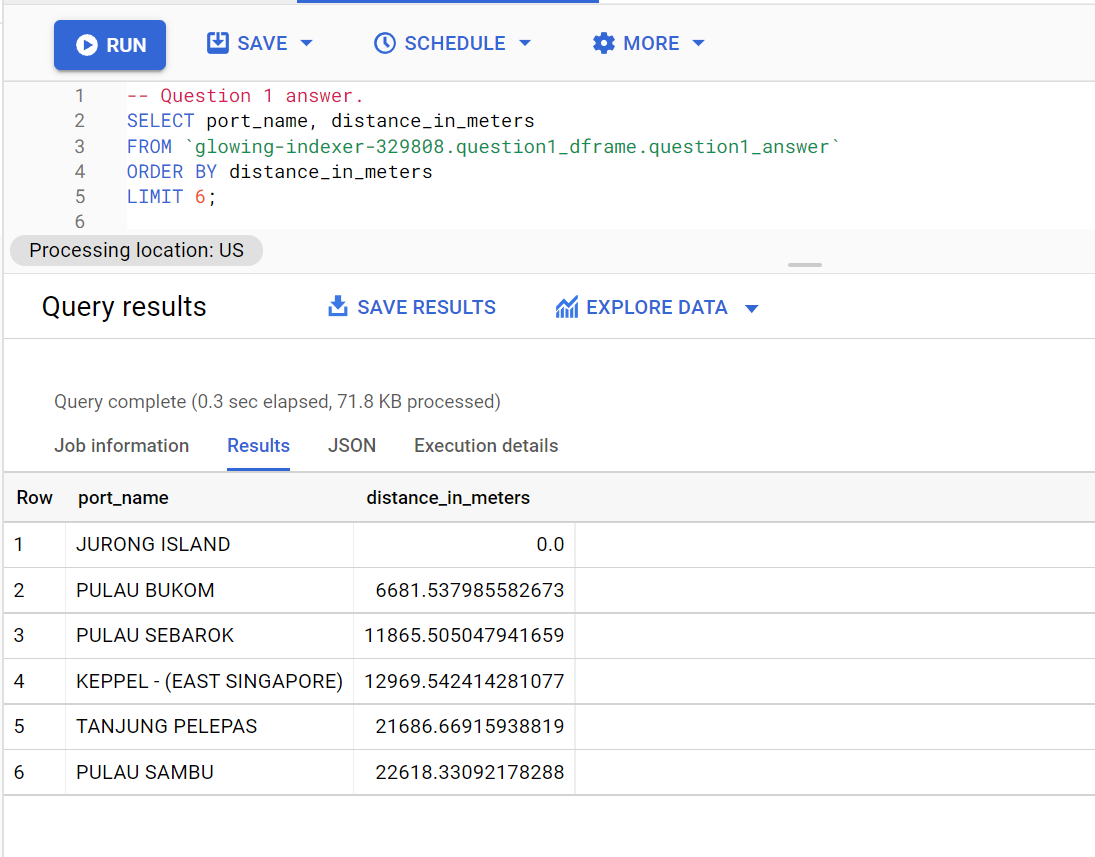

# Question 2

Q2/ Which country has the largest number of ports with a cargo_wharf? Your answer should include
the columns country and port_count only.

In [13]:
# Execute SQL query to get the largest number of ports with cargo_wharf from Colab to BigQuery 
%%bigquery --project glowing-indexer-329808 

SELECT country, Count(*) AS port_count
FROM `bigquery-public-data.geo_international_ports.world_port_index`
WHERE cargo_wharf = TRUE 
GROUP BY country
ORDER BY port_count DESC 
LIMIT 1;

,country,port_count
0,US,583


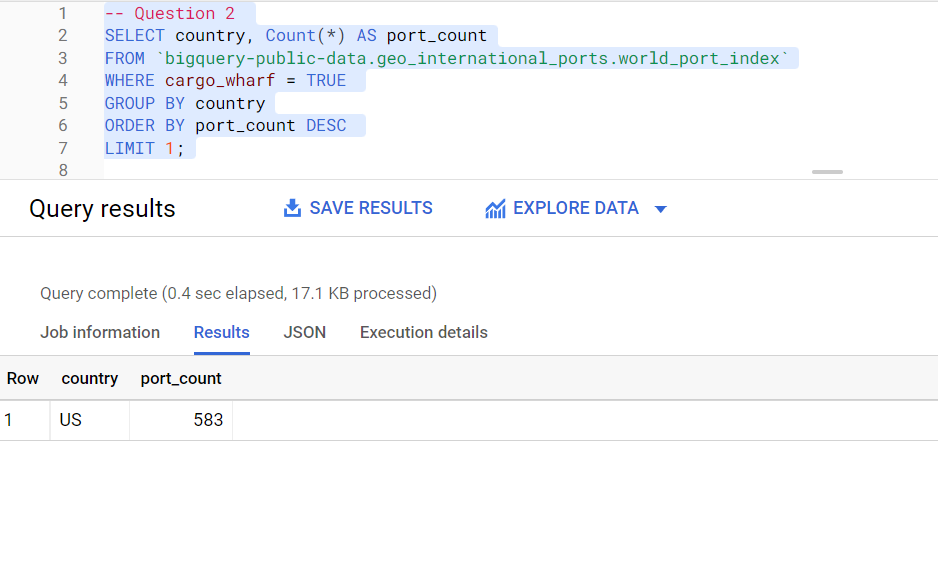

# Question 3

Q3/ You receive a distress call from the middle of the North Atlantic Ocean. The person on the line gave you
a coordinates of lat: 32.610982, long: -38.706256 and asked for the nearest port with
provisions, water, fuel_oil and diesel. Your answer should include the columns
country, port_name, port_latitude and port_longitude only.

In [14]:
# Outputs the mumber of columns and rows residing in the Pandas DataFrame -> world_port_index_dframe
world_port_index_dframe.shape

(3669, 73)

In [15]:
# Duplicate Dataframe instance of Pandas DataFrame -> world_port_index_dframe for Question 3's analysis. 
# Name of the duplicated Dataframe instance -> question3_dframe
question3_dframe = world_port_index_dframe.copy()

# An empty List for storing distance (in Meters)
calculated_distance = []

# Outline the number of columns and rows of the duplicated Dataframe instance -> question3_dframe
question3_dframe.shape

(3669, 73)

In [16]:
# Capturing the given coordinates. 
given_coordinates_lat = 32.610982
given_coordinates_long = -38.706256

given_coordinates = given_coordinates_lat, given_coordinates_long

In [17]:
# Reusing question 1's for loop code
# Calculate distance (in meters) for the whole world port's location coordinates with the given coordinates. 

for index, row in question3_dframe.iterrows():
  country_location = float(row["port_latitude"]), float(row["port_longitude"])
  distance = haversine(country_location,given_coordinates, unit=Unit.METERS)
  calculated_distance.append(distance)

# Inserting an new column, "distance_in_meters", into the duplicated DataFrame instance -> question3_dframe 
question3_dframe["distance_in_meters"] = calculated_distance

In [18]:
save_search_results = question3_dframe.loc[(question3_dframe["provisions"] == True) & (question3_dframe["water"] == True) & (question3_dframe["fuel_oil"] == True) & (question3_dframe["diesel"] == True), ["country","port_name","port_latitude","port_longitude", "distance_in_meters"]]

In [19]:
save_search_results.sort_values("distance_in_meters", ascending=True).head()

,country,port_name,port_latitude,port_longitude,distance_in_meters
2429,PT,HORTA,38.533333,-28.633333,1.122970e+06
531,PT,PRAIA DE VITORIA,38.716667,-27.050000,1.251335e+06
2430,PT,PONTA DELGADA,37.733333,-25.666667,1.313320e+06
1396,PT,FUNCHAL,32.633333,-16.916667,2.037061e+06
945,CA,ST JOHN'S,47.566667,-52.700000,2.038265e+06


In [20]:
# Uploading Dataframe results into my project -> BigQuery platform 
question3_answer_dataset = "save_search_results.question3_answer"
gbq.to_gbq(save_search_results, question3_answer_dataset,project_id)

1it [00:03,  3.93s/it]


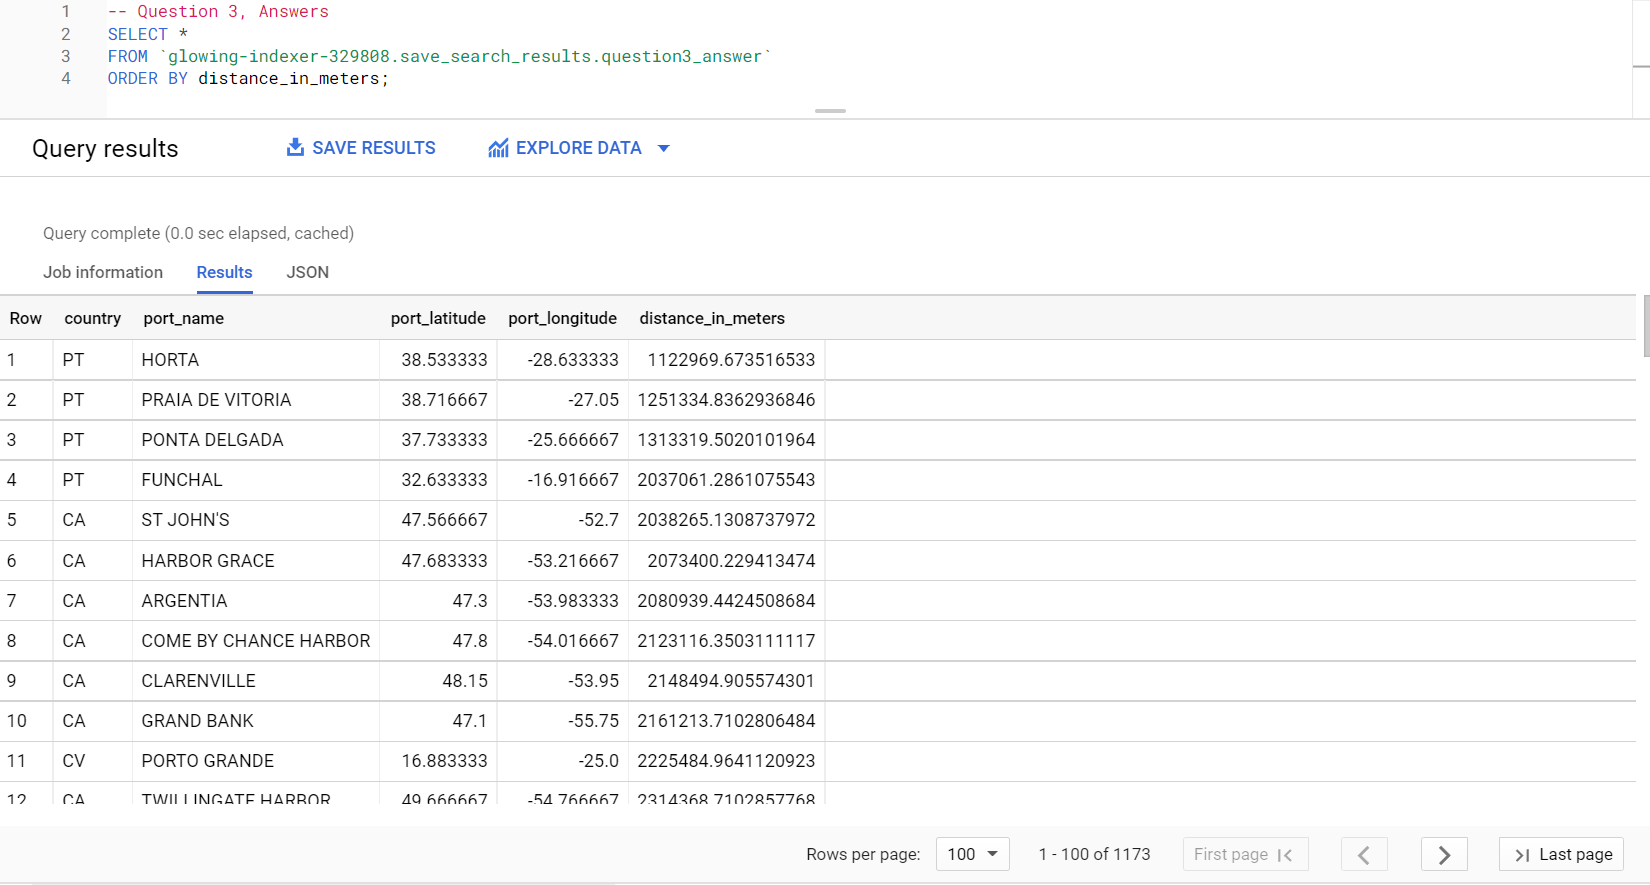